In [60]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [193]:
cities = [
#     ('New York City',  [
#         'Kings County, NY','Queens County, NY', 'New York County, NY','Bronx County, NY',
# 'Richmond County, NY','Westchester County, NY','Bergen County, NJ','Hudson County, NJ',
# 'Passaic County, NJ','Putnam County, NY','Rockland County, NY','Suffolk County, NY',
# 'Nassau County, NY','Middlesex County, NJ','Monmouth County, NJ','Ocean County, NJ',
# 'Somerset County, NJ','Essex County, NJ','Union County, NJ','Morris County, NJ',
# 'Sussex County, NJ','Hunterdon County, NJ','Pike County, PA',]),
    
#     ('Los Angeles', ['Los Angeles County, CA','Orange County, CA',
#                  'San Bernardino County, CA', 'Riverside County, CA', 'Ventura County, CA']),
    
#     ('Chicago', [
#         'Cook County, IL','DeKalb County, IL','DuPage County, IL','Grundy County, IL',
# 'Kankakee County, IL','Kane County, IL','Kendall County, IL','McHenry County, IL',
# 'Will County, IL','Jasper County, IN','Lake County, IN','Newton County, IN',
# 'Porter County, IN','Lake County, IL', 'Kenosha County, WI'
#     ]),
    
#     ('Houston', ['Harris County, TX','Austin County, TX','Brazoria County, TX',
# 'Chambers County, TX','Fort Bend County, TX','Galveston County, TX','Harris County, TX',
# 'Liberty County, TX','Montgomery County, TX','Waller County, TX']),
    
#     ('Boston', ['Suffolk County, MA','Plymouth County, MA',
#                       'Norfolk County, MA','Essex County, MA', 'Middlesex County, MA',
#                      'Rockingham County, NH', 'Strafford County, NH']),

#     ('Phoenix', ['Maricopa County, AZ','Pinal County, AZ','Gila County, AZ']),
#     ('Philadelphia', ['Burlington County, NJ','Camden County, NJ','Gloucester County,NJ',
#      'Bucks County, PA', 'Chester County, PA', 'Montgomery County, PA',
#                            'Delaware County, PA', 'Philadelphia County, PA',
#                            'New Castle County, DE', 'Cecil County, MD', 'Salem County, NJ']),

    
#     ('Dallas',  ['Collin County, TX','Dallas County, TX','Denton County, TX','Ellis County, TX',
# 'Hunt County, TX','Kaufman County, TX','Rockwall County, TX','Johnson County, TX','Parker County, TX',
# 'Tarrant County, TX','Wise County, TX']),
    
     ('Austin', ['Williamson County, TX','Travis County, TX','Bastrop County, TX','Hays County, TX','Caldwell County, TX'])


]

In [123]:
cities = os.listdir('processedOD/')
cities = [i.split('.')[0] for i in cities if '.csv' in i]
cities

['Los Angeles', 'Calhoun', 'Chicago', 'New York City']

# baseline

### unconstrain model, power law

In [70]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [83]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [84]:
minValue = []
maxValue = []
for city in cities:
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
#     df = pd.to_csv(f'income/{city}.csv',index=)
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-5.181238581271904 5.020043037266068


In [85]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [86]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.002*len(df)),2000)
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)

            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [ ]:

# hyper-parameter tuning

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 2000
for rate in np.arange(0.0007,0.01,0.0001):
    fdworsecounttemp = 0
    for city, counties in cities:
        print(city)
        df = pd.read_csv(f'processedOD/{city}.csv')
        df['distance'] = df['distance']/1.6
        df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(0.5),np.log(50),40+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)

        binfdf = pd.DataFrame()

        # fd
        for target in ['SE01','SE03','S000']:
            traindf, testdf = train_test_split(df, test_size=0.2)
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            print(target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
            resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                    [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
            resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                    [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

            fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
            print('is',round(fdmseis,2),
                  'os',round(fdmseos,2))
        # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
                [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
            resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
                [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

            blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            print('is',round(blmseis,2),
                  'os',round(blmseos,2))
            if fdmseos > blmseos:
                fdworsecounttemp += 1
    fdworsecount += [fdworsecounttemp]

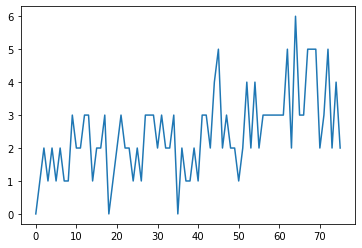

In [18]:
plt.plot(fdworsecount)

In [17]:


# 5-fold 
resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
number = 2000
fdworsecounttemp = 0
rate = np.arange(0.0007,0.01,0.0001)[20]
for city, counties in cities:
    print(city)
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),40+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
        # fd
    for target in ['SE01','SE03','S000']:
        print(target)

        fdmseis = 0
        fdmseos = 0
        blmseis = 0
        blmseos = 0
        for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
            traindf, testdf = df.iloc[train_index], df.iloc[test_index]
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            fdmseis += mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos += mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
           
        
            # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            
        resultsfd40is[city] = resultsfd40is.get(city,[])+ [round(fdmseis/5,2)]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ [round(fdmseos/5,2)]
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + [round(blmseis/5,2)]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + [round(blmseos/5,2)]
        print('is',round(fdmseis/5,2),'os',round(fdmseos/5,2))
        print('is',round(blmseis/5,2),'os',round(blmseos/5,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1


New York City
SE01
is 0.23 os 0.23
is 0.23 os 0.23
SE03
is 0.76 os 0.76
is 0.76 os 0.76
S000
is 1.43 os 1.43
is 1.43 os 1.43
Los Angeles
SE01
is 0.32 os 0.33
is 0.32 os 0.32
SE03
is 0.64 os 0.64
is 0.64 os 0.64
S000
is 1.5 os 1.52
is 1.51 os 1.51
Chicago
SE01
is 0.22 os 0.22
is 0.22 os 0.22
SE03
is 0.68 os 0.68
is 0.68 os 0.68
S000
is 1.3 os 1.3
is 1.3 os 1.3
Dallas
SE01
is 0.22 os 0.22
is 0.22 os 0.22
SE03
is 0.81 os 0.81
is 0.81 os 0.81
S000
is 1.58 os 1.58
is 1.58 os 1.58
Atlanta
SE01
is 0.26 os 0.26
is 0.26 os 0.26
SE03
is 0.87 os 0.87
is 0.87 os 0.87
S000
is 1.76 os 1.76
is 1.76 os 1.76
DC
SE01
is 0.26 os 0.26
is 0.26 os 0.26
SE03
is 1.12 os 1.13
is 1.13 os 1.13
S000
is 2.25 os 2.26
is 2.26 os 2.26
San Francisco
SE01
is 0.17 os 0.17
is 0.17 os 0.17
SE03
is 0.94 os 0.94
is 0.94 os 0.94
S000
is 1.42 os 1.42
is 1.42 os 1.42


In [28]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,1.431700,1.430667,0.228857,0.228779,0.759871,0.759585
Los Angeles,1.516365,1.513302,0.324804,0.324346,0.634577,0.634349
Chicago,1.298120,1.296833,0.223502,0.223467,0.682732,0.682514
Dallas,1.587507,1.586794,0.223991,0.223945,0.816796,0.816655
Atlanta,1.755799,1.753811,0.262048,0.261976,0.871500,0.871131
DC,2.242135,2.238825,0.261731,0.261553,1.137092,1.136603
San Francisco,1.421585,1.419589,0.168169,0.167999,0.947434,0.946870


In [29]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,1.431870,1.431780,0.226681,0.226719,0.769487,0.769682
Los Angeles,1.478622,1.487833,0.320273,0.323932,0.651743,0.651674
Chicago,1.306274,1.305214,0.223399,0.223393,0.666982,0.667190
Dallas,1.554175,1.554609,0.218874,0.218870,0.793782,0.793848
Atlanta,1.789144,1.792867,0.262870,0.262894,0.848148,0.848167
DC,2.318745,2.325092,0.260669,0.261052,1.076791,1.078813
San Francisco,1.416838,1.418423,0.166872,0.166836,0.929619,0.930352


In [96]:
df = pd.read_csv(f'processedOD/{city}.csv')
len(df)

7926623

In [146]:

# one iteration, no cross-validation to get data to plot

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 5000
fdworsecounttemp = 0
# rate = np.arange(0.0007,0.01,0.0001)[40]
rate = 0.05
for city in cities[1:2]:
    print(city)
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),30+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
#     distBin = np.linspace(0.5,50,30+1)
#     df['bin'] = df.distance.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        traindf, testdf = train_test_split(df, test_size=0.2)
        binf,k = unconstrained_bucked_constant_kfit(traindf, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
        df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

        fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
        fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
        print('is',round(fdmseis,2),
              'os',round(fdmseos,2))
    # baseline 
        pars = baseline_fit(traindf,target)
        df_baselineis = baseline_predict(traindf,target,pars)
        df_baselineos = baseline_predict(testdf,target,pars)
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
            [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
            [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

        blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
        blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
        print('is',round(blmseis,2),
              'os',round(blmseos,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1
fdworsecount += [fdworsecounttemp]

Calhoun
SE01
is 0.27 os 0.28
is 0.27 os 0.28
SE03
is 0.4 os 0.4
is 0.4 os 0.4
S000
is 1.07 os 1.06
is 1.07 os 1.06


In [147]:
# convert bins back to distance median
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

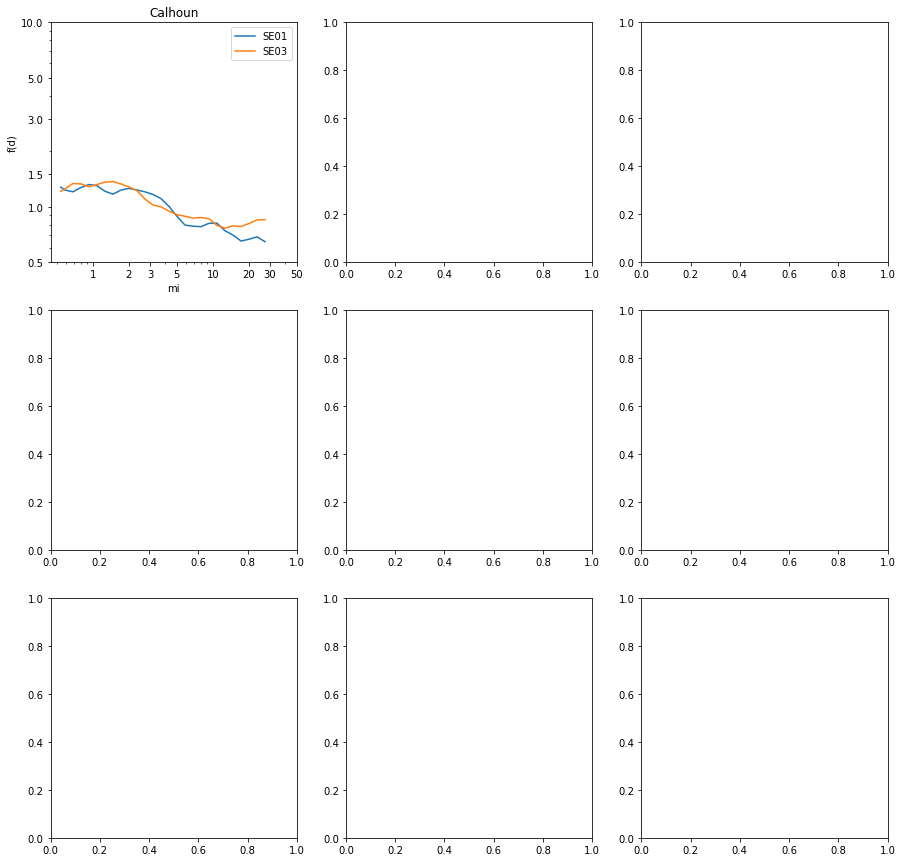

In [148]:


fig,ax = plt.subplots(3,3,figsize=(15,15))
i= 0
for city in cities[1:2]:

    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    df = df.sort_values(by='bin')
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('mi')
    i += 1

# plt.savefig('curve.png')